In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from torchmetrics.image import LearnedPerceptualImagePatchSimilarity
import torch
torch.cuda.empty_cache()
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = False
torch.multiprocessing.set_sharing_strategy('file_system')

import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (8192, rlimit[1]))

# from kornia.color import GrayscaleToRgb
# from kornia.augmentation import Normalize

from monai.visualize.img2tensorboard import plot_2d_or_3d_image
from monai.networks.layers import * #Reshape
from monai.networks.nets import * #UNet, DenseNet121, Generator
from monai.losses import DiceLoss

from data import *

/home/quantm/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2022-10-05 16:02:27,782 - Created a temporary directory at /tmp/tmpsrwv3jlj
2022-10-05 16:02:27,784 - Writing /tmp/tmpsrwv3jlj/_remote_module_non_scriptable.py


In [2]:
SHAPE = 256
SEED = 42
BATCH_SIZE = 1
DATADIR = "data"
DEVICE = torch.device("cpu")

train_image3d_folders = [
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/Verse2019/raw/train/rawdata/'),
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/Verse2020/raw/train/rawdata/'),
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/Verse2019/raw/val/rawdata/'),
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/Verse2020/raw/val/rawdata/'),
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/Verse2019/raw/test/rawdata/'),
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/Verse2020/raw/test/rawdata/'),

    # os.path.join(DATADIR, 'SpineXRVertSegmentation/UWSpine/processed/train/images'),
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/UWSpine/processed/test/images/'),

    os.path.join(DATADIR, 'ChestXRLungSegmentation/NSCLC/processed/train/images'),
    os.path.join(DATADIR, 'ChestXRLungSegmentation/MOSMED/processed/train/images/CT-0'),
    os.path.join(DATADIR, 'ChestXRLungSegmentation/MOSMED/processed/train/images/CT-1'),
    os.path.join(DATADIR, 'ChestXRLungSegmentation/MOSMED/processed/train/images/CT-2'),
    os.path.join(DATADIR, 'ChestXRLungSegmentation/MOSMED/processed/train/images/CT-3'),
    os.path.join(DATADIR, 'ChestXRLungSegmentation/MOSMED/processed/train/images/CT-4'),
    os.path.join(DATADIR, 'ChestXRLungSegmentation/Imagenglab/processed/train/images'),
]
train_label3d_folders = [

]

train_image2d_folders = [
    # os.path.join(DATADIR, 'ChestXRLungSegmentation/JSRT/processed/images/'), 
    # os.path.join(DATADIR, 'ChestXRLungSegmentation/ChinaSet/processed/images/'), 
    # os.path.join(DATADIR, 'ChestXRLungSegmentation/Montgomery/processed/images/'),
    os.path.join(DATADIR, 'ChestXRLungSegmentation/VinDr/v1/processed/train/images/'), 
    # os.path.join(DATADIR, 'ChestXRLungSegmentation/VinDr/v1/processed/test/images/'), 
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/T62020/20200501/raw/images'), 
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/T62021/20211101/raw/images'), 
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/VinDr/v1/processed/train/images/'), 
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/VinDr/v1/processed/test/images/'), 
]
train_label2d_folders = [
]

val_image3d_folders = train_image3d_folders
val_image2d_folders = [
    # os.path.join(DATADIR, 'ChestXRLungSegmentation/JSRT/processed/images/'), 
    # os.path.join(DATADIR, 'ChestXRLungSegmentation/ChinaSet/processed/images/'), 
    # os.path.join(DATADIR, 'ChestXRLungSegmentation/Montgomery/processed/images/'),
    # os.path.join(DATADIR, 'ChestXRLungSegmentation/VinDr/v1/processed/train/images/'), 
    os.path.join(DATADIR, 'ChestXRLungSegmentation/VinDr/v1/processed/test/images/'), 
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/T62020/20200501/raw/images'), 
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/T62021/20211101/raw/images'), 
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/VinDr/v1/processed/train/images/'), 
    # os.path.join(DATADIR, 'SpineXRVertSegmentation/VinDr/v1/processed/test/images/'), 
]

test_image3d_folders = val_image3d_folders
test_image2d_folders = val_image2d_folders

datamodule = OrDiffDataModule(
    train_image3d_folders = train_image3d_folders, 
    train_image2d_folders = train_image2d_folders, 
    val_image3d_folders = val_image3d_folders, 
    val_image2d_folders = val_image2d_folders, 
    test_image3d_folders = test_image3d_folders, 
    test_image2d_folders = test_image2d_folders, 
    batch_size = BATCH_SIZE, 
    shape = SHAPE
)
datamodule.setup(seed=SEED)
debug_data = first(datamodule.train_dataloader())
image3d, image2d = (debug_data["image3d"][0][0], debug_data["image2d"][0][0])
print(f"image3d shape: {image3d.shape}, \
        image2d shape: {image2d.shape}")
image3d = image3d.to(DEVICE)
image2d = image2d.to(DEVICE)


1544
['data/ChestXRLungSegmentation/Imagenglab/processed/train/images/001.nii.gz']
15000
['data/ChestXRLungSegmentation/VinDr/v1/processed/train/images/000434271f63a053c4128a0ba6352c7f.png']
1544
['data/ChestXRLungSegmentation/Imagenglab/processed/train/images/001.nii.gz']
3000
['data/ChestXRLungSegmentation/VinDr/v1/processed/test/images/002a34c58c5b758217ed1f584ccbcfe9.png']
1544
['data/ChestXRLungSegmentation/Imagenglab/processed/train/images/001.nii.gz']
3000
['data/ChestXRLungSegmentation/VinDr/v1/processed/test/images/002a34c58c5b758217ed1f584ccbcfe9.png']


<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


image3d shape: (256, 256, 256),         image2d shape: (256, 256)


(256, 256, 256)
(512, 512)


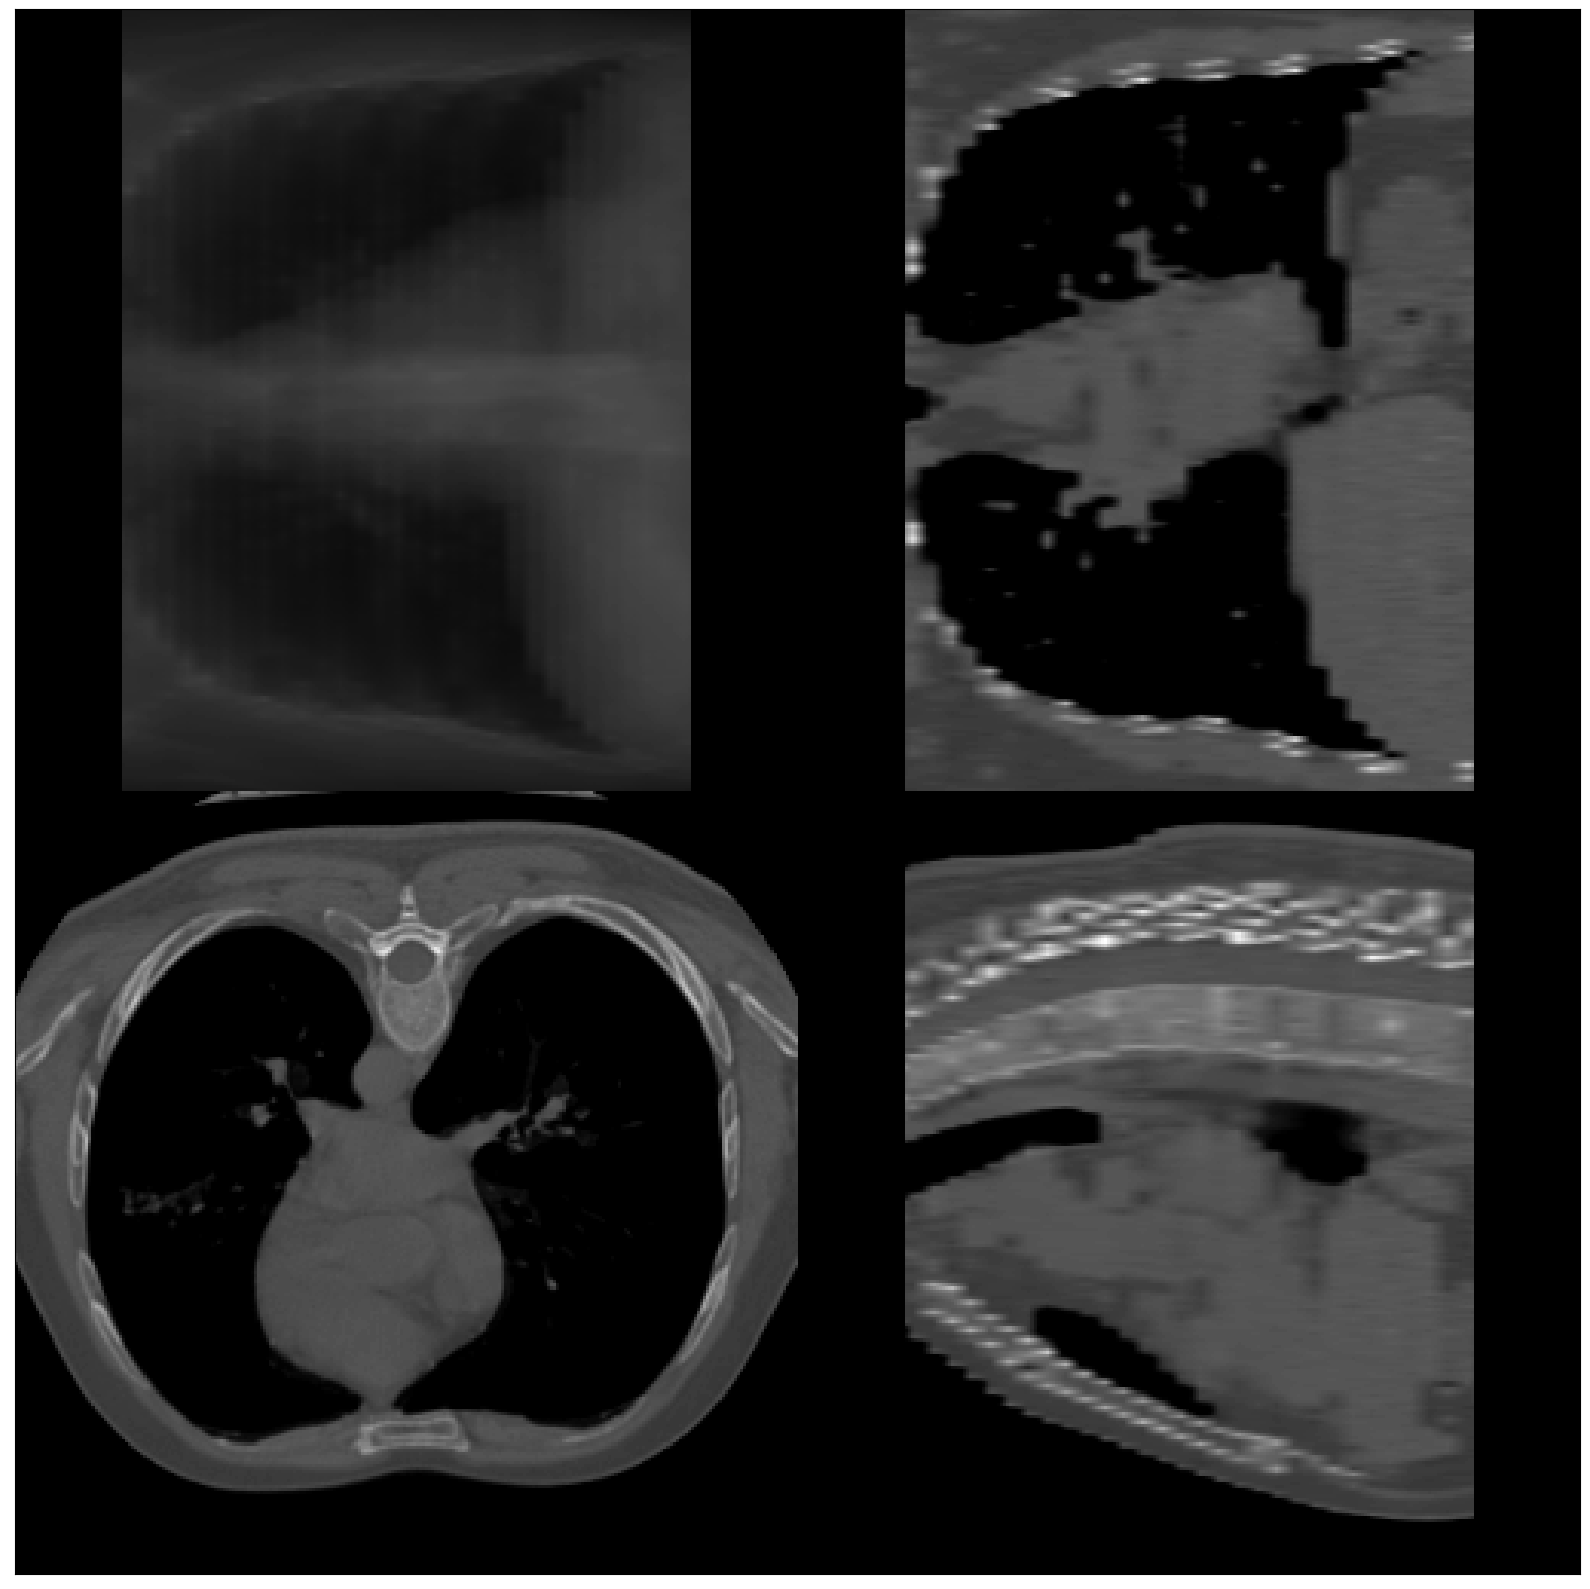

In [3]:
def plot_diff(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(16, 16), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [imgs] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

def make_four(volume):
    print(volume.shape)
    xray = volume.mean(axis=-3) #.transpose()[:,::-1]
    p_yz = volume[:,SHAPE//2,:].squeeze() #.transpose()[:,::-1]
    p_xz = volume[SHAPE//2,:,:].squeeze() #.transpose()[:,::-1]
    p_xy = volume[:,:,SHAPE//2].squeeze() #[:,::-1]
    cat = np.concatenate([
        np.concatenate([xray, p_xz], axis=1),
        np.concatenate([p_xy, p_yz], axis=1),
    ], axis=0)
    print(cat.shape)
    return cat

plot_diff(
    [make_four((image3d.cpu().numpy()*255).astype(np.uint8))],
    cmap=plt.cm.gray
)

In [29]:
timesteps = 256

# forward diffusion (using the nice property)
def q_sample(x_start, t):
    # if noise is None:
    #     noise = torch.randn_like(x_start)

    # sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    # sqrt_one_minus_alphas_cumprod_t = extract(
    #     sqrt_one_minus_alphas_cumprod, t, x_start.shape
    # )

    # return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    # transforms = Compose(
    #     [
    #         monai.transforms.AddChannel(),
    #         monai.transforms.Resize(spatial_size=( (timesteps-t), SHAPE, SHAPE), mode="trilinear", anti_aliasing=False),
    #         monai.transforms.Resize(spatial_size=( SHAPE, SHAPE, SHAPE), mode="trilinear", anti_aliasing=False),
    #         # monai.transforms.Spacing(t/timesteps, 1.0, 1.0),
    #         # monai.transforms.Spacing(1.0, 1.0, 1.0)
    #     ]
    # )
    # return transforms(x_start).squeeze()
    tensor = monai.transforms.AddChannel()(x_start)
    # minimized = monai.transforms.Resample(align_corners=False)(tensor, spatial_size=( (timesteps-t), SHAPE, SHAPE))
    minimized = monai.transforms.Resize(spatial_size=( (timesteps-t), SHAPE, SHAPE), mode="trilinear", anti_aliasing=False)(tensor)
    maximized = monai.transforms.SpatialResample(align_corners=True)(minimized, spatial_size=( SHAPE, SHAPE, SHAPE))
    return maximized.squeeze()
    
def get_under_image(x_start, t):
    # add noise
    x_under = q_sample(x_start, t=t)
    print(x_start.shape, x_under.shape)
    return x_under

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


(256, 256, 256) (256, 256, 256)
(256, 256, 256)
(512, 512)
(256, 256, 256) (256, 256, 256)
(256, 256, 256)
(512, 512)
(256, 256, 256) (256, 256, 256)
(256, 256, 256)
(512, 512)


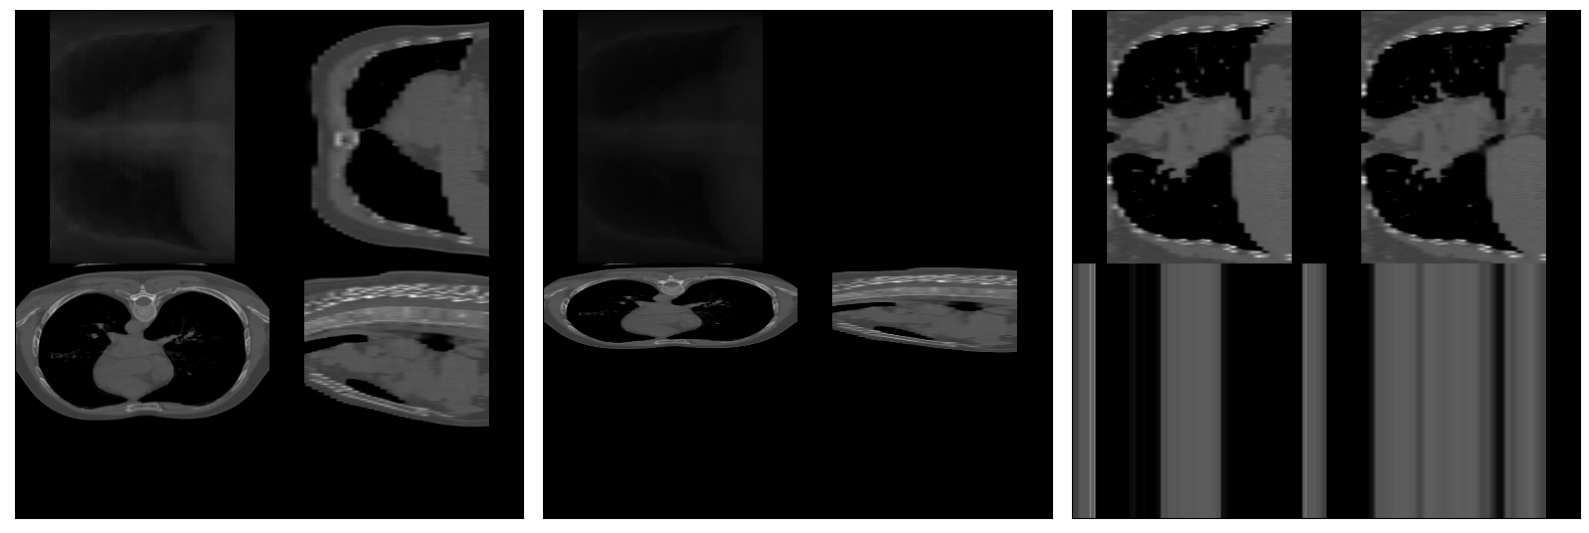

In [30]:
plot_diff(
    [
        make_four(
            get_under_image( image3d, torch.tensor([t]) )
        ) for t in [80, 160, 255]
    ],
    cmap=plt.cm.gray
)